In [44]:
import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


In [45]:


# set location of input files:
inpDir = os.path.join('input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.2

<Figure size 1500x500 with 0 Axes>

In [46]:
def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [47]:
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [48]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [49]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

clf = SVC (kernel='linear')

X, y = make_blobs(n_samples=50, centers=2, random_state=RANDOM_STATE, cluster_std=0.60)
clf.fit(X,y)

SVC(kernel='linear')

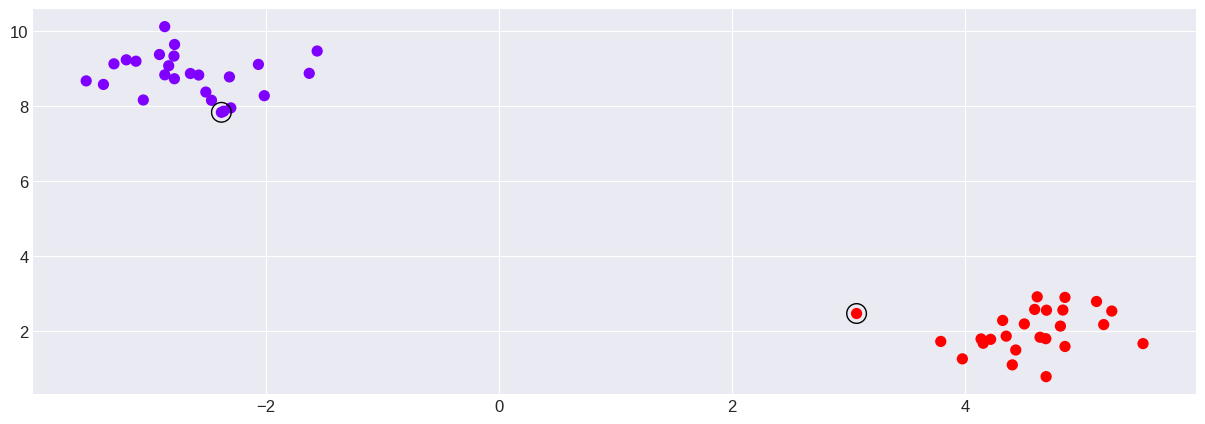

In [50]:
plt.scatter(X[: , 0], X[: , 1], c=y, s=50, cmap=CMAP)
plt.scatter(clf.support_vectors_[:,0],
            clf.support_vectors_[:, 1],s=200,edgecolors='k',facecolor='None')

In [51]:

data_df = pd.read_csv( 'breast_cancer_mod.csv')
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,1,...,1,0,1,0,1,1,0,1,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0


In [52]:
data_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,1,...,1,0,1,0,1,1,0,1,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
566,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
567,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [53]:
data_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.00000,569.000000
mean,0.820738,0.880492,0.827768,0.954306,0.811951,0.910369,0.917399,0.899824,0.831283,0.927944,...,0.790861,0.868190,0.966608,0.762742,0.942004,0.926186,0.678383,0.956063,0.97891,0.627417
std,0.383909,0.324671,0.377914,0.209005,0.391095,0.285904,0.275520,0.300498,0.374831,0.258809,...,0.407052,0.338582,0.179816,0.425776,0.233942,0.261698,0.467508,0.205135,0.14381,0.483918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [54]:
data_df.target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

[Text(1, 0, 'Malignant'), Text(0, 0, 'Benign')]

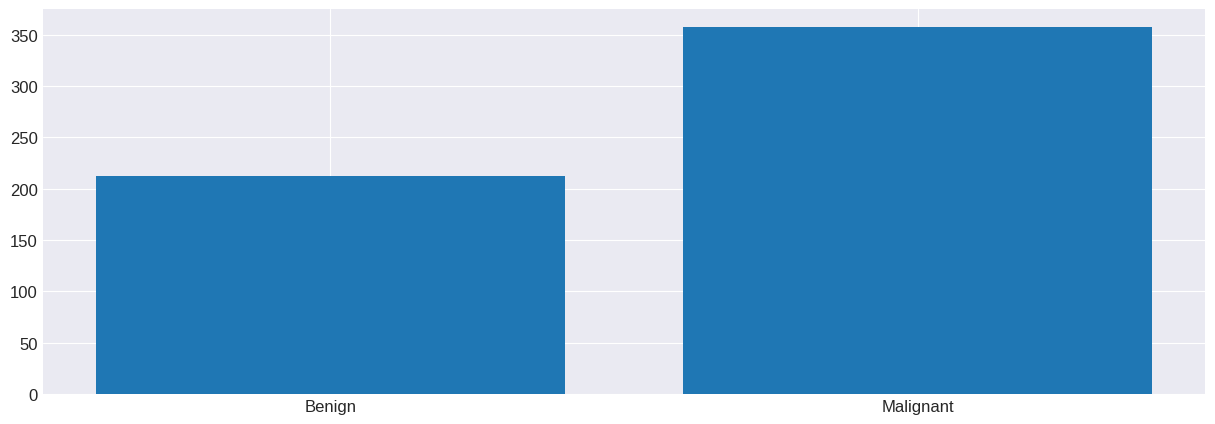

In [55]:
class_names= ['Malignant', 'Benign']
fig, ax = plt.subplots()
ax.bar(data_df.target.value_counts().index, data_df.target.value_counts())
ax.set_xticks(data_df.target.value_counts().index)
ax.set_xticklabels(class_names)

In [56]:
features_df=data_df.drop('target', axis=1)

labels_df = data_df.target

In [57]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df,
                                                    test_size=TEST_SIZE, stratify=labels_df, random_state=RANDOM_STATE)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [58]:
X_train['total'] = X_train.astype(np.int16).sum(axis = 1)
X_train['target'] = y_train
X_train.sort_values('total', inplace=True)
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,total,target
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,1,1,12,0
2,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,13,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,14,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,14,0
8,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,1,1,15,0


In [59]:
X_test['total'] = X_test.astype(np.int16).sum(axis = 1)
X_test['target'] = y_test
X_test.sort_values('total', inplace=True)
X_test.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,total,target
1,0,1,0,0,0,0,0,0,0,1,...,0,1,0,1,1,0,1,1,13,0
14,0,1,0,1,0,0,0,0,0,1,...,0,1,0,1,1,0,0,1,17,0
20,1,1,1,1,1,0,1,1,0,0,...,1,1,0,0,0,0,0,0,18,0
21,1,1,1,1,0,0,1,1,0,0,...,1,1,0,0,0,0,0,0,19,0
32,1,1,1,1,1,1,0,1,0,0,...,1,1,1,1,0,0,1,1,20,1


<Axes: xlabel='total'>

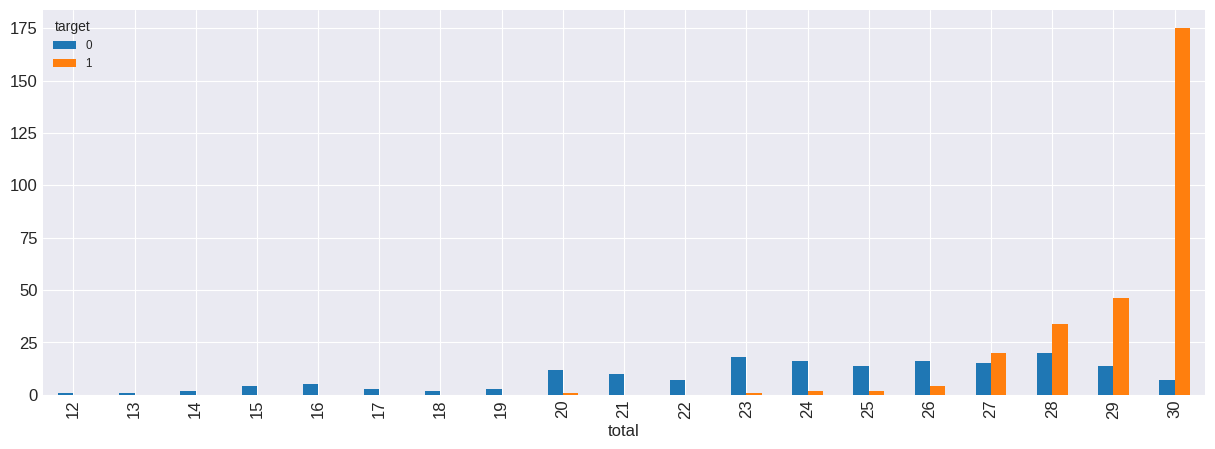

In [60]:
tmp_df = X_train.groupby(['total','target']).agg({'target':'count'})
tmp_df.columns = ['count']
tmp_df.reset_index(inplace= True)
tmp_df.pivot(index = 'total', columns= 'target', values='count').plot(kind = 'bar')

<Axes: xlabel='total'>

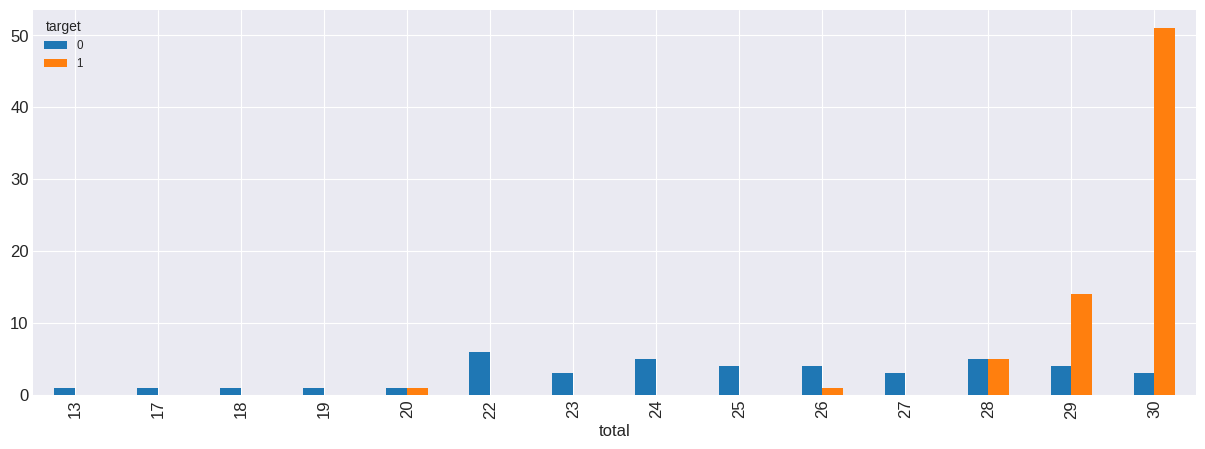

In [61]:
tmp_df = X_test.groupby(['total','target']).agg({'target':'count'})
tmp_df.columns = ['count']
tmp_df.reset_index(inplace= True)
tmp_df.pivot(index = 'total', columns= 'target', values='count').plot(kind = 'bar')

In [62]:
accuracy = {}
for b in np.arange(X_train.shape[1]):
    X_train['pred'] = X_train['total'] >= b
    accuracy[b] = accuracy_score(X_train['pred'], X_train['target'])

In [63]:
accuracy

{0: 0.6263736263736264,
 1: 0.6263736263736264,
 2: 0.6263736263736264,
 3: 0.6263736263736264,
 4: 0.6263736263736264,
 5: 0.6263736263736264,
 6: 0.6263736263736264,
 7: 0.6263736263736264,
 8: 0.6263736263736264,
 9: 0.6263736263736264,
 10: 0.6263736263736264,
 11: 0.6263736263736264,
 12: 0.6263736263736264,
 13: 0.6285714285714286,
 14: 0.6307692307692307,
 15: 0.6351648351648351,
 16: 0.643956043956044,
 17: 0.654945054945055,
 18: 0.6615384615384615,
 19: 0.6659340659340659,
 20: 0.6725274725274726,
 21: 0.6967032967032967,
 22: 0.7186813186813187,
 23: 0.734065934065934,
 24: 0.7714285714285715,
 25: 0.8021978021978022,
 26: 0.8285714285714286,
 27: 0.8549450549450549,
 28: 0.843956043956044,
 29: 0.8131868131868132,
 30: 0.7428571428571429,
 31: 0.37362637362637363}

In [70]:
best_b=max(accuracy, key=accuracy.get)

print('highest accuracy was {1:7.3f} at threshold of {0:4d}'.format(best_b, accuracy[best_b]))

highest accuracy was   0.855 at threshold of   27


In [74]:
X_test['pred']= X_test['total'] >= best_b
accuracy_test = accuracy_score(X_test['pred'], X_test['target'])
print('test accuracy was {0:6.3f}'.format(accuracy_test))

test accuracy was  0.851
